#Libs

In [ ]:
#@title Install libs
!pip install catboost
!pip install ccxt

"""
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
"""

!pip install TA-Lib-Precompiled
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [ ]:
from logging import warning
#@title Load libs
import numpy as np

# Data Management
import pandas as pd

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Sampling Methods
from imblearn.over_sampling import ADASYN

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay as plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

from hyperopt import fmin, tpe, hp
from pandas_datareader.data import DataReader

import json
from datetime import datetime
import talib as ta
import ccxt

import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle as pk
import joblib

#Functions

In [ ]:
def get_indicators(data, timeframes, volatility_look_back, supertrend_multiplier=3):
    df = data.copy()

    for timeframe in timeframes:
        df[f'ATR_{timeframe}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
        df[f'RSI_{timeframe}'] = ta.RSI(df['close'], timeperiod=timeframe)
        df[f'VWAP_{timeframe}'] = ta.SUM(df['volume'] * (df['high'] + df['low'] + df['close']) / 3, timeperiod=timeframe) / ta.SUM(df['volume'], timeperiod=timeframe)
        df['ema'] = ta.EMA(df['close'], timeperiod=timeframe)

        df[f'CCI_{timeframe}'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=timeframe)

        # Оптимизированный расчет DPO и добавление как остальные индикаторы
        if len(df) >= timeframe:
            offset = timeframe // 2 + 1
            sma = df['close'].rolling(window=timeframe).mean()
            shifted_close = df['close'].shift(offset)
            df[f'DPO_{timeframe}'] = shifted_close - sma
        else:
            df[f'DPO_{timeframe}'] = np.nan

        df[f'EWO_{timeframe}'] = ta.SMA(df['close'], timeperiod=(timeframe+5)) - ta.SMA(df['close'], timeperiod=(timeframe+35))

        # Добавляем недостающие индикаторы в цикл
        df[f'KC_upper_{timeframe}'] = ta.EMA(df['high'], timeperiod=timeframe)
        df[f'KC_middle_{timeframe}'] = ta.EMA(df['low'], timeperiod=timeframe)
        df[f'Donchian_upper_{timeframe}'] = ta.MAX(df['high'], timeperiod=timeframe)
        df[f'Donchian_lower_{timeframe}'] = ta.MIN(df['low'], timeperiod=timeframe)
        df[f'Donchian_center_{timeframe}'] = (df[f'Donchian_upper_{timeframe}'] + df[f'Donchian_lower_{timeframe}']) / 2
        macd, macd_signal, _ = ta.MACD(df['close'], fastperiod=(timeframe + 12), slowperiod=(timeframe + 26), signalperiod=(timeframe + 9))
        df[f'MACD_{timeframe}'] = macd
        df[f'MACD_signal_{timeframe}'] = macd_signal
        bb_upper, bb_middle, bb_lower = ta.BBANDS(df['close'], timeperiod=timeframe, nbdevup=2, nbdevdn=2)
        df[f'BB_upper_{timeframe}'] = bb_upper
        df[f'BB_middle_{timeframe}'] = bb_middle
        df[f'BB_lower_{timeframe}'] = bb_lower

        # Calculate Supertrend for the current timeframe
        atr_period = timeframe
        atr_multiplier = supertrend_multiplier
        atr = ta.ATR(df['high'], df['low'], df['close'], timeperiod=atr_period)
        upper_band = df['high'] + atr_multiplier * atr
        lower_band = df['low'] - atr_multiplier * atr
        supertrend = np.zeros(len(df))
        in_uptrend = True

        for i in range(atr_period, len(df)):
            current_close = df['close'].iloc[i]
            previous_close = df['close'].iloc[i-1]

            if i == atr_period:
                supertrend[i] = upper_band.iloc[i]
            else:
                if supertrend[i-1] == upper_band.iloc[i-1]:
                    if current_close <= upper_band.iloc[i]:
                        supertrend[i] = upper_band.iloc[i]
                    else:
                        supertrend[i] = lower_band.iloc[i]
                        in_uptrend = False
                else:
                    if current_close >= lower_band.iloc[i]:
                        supertrend[i] = lower_band.iloc[i]
                        in_uptrend = True
                    else:
                        supertrend[i] = upper_band.iloc[i]

            if in_uptrend:
                supertrend[i] = max(supertrend[i-1], lower_band.iloc[i])
            else:
                supertrend[i] = min(supertrend[i-1], upper_band.iloc[i])

        df[f'Supertrend_{timeframe}'] = supertrend

    df["returns"] = (df["close"] / df["close"].shift(volatility_look_back)) - 1
    df["range"] = (df["high"] / df["low"]) - 1
    df["volatility"] = df['returns'].rolling(window=volatility_look_back).std()

    # Volume-Based Indicators
    df['ADL'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ROC'] = ta.ROC(df['close'], timeperiod=volatility_look_back)
    df['OBV'] = ta.OBV(df['close'], df['volume'])
    # Momentum-Based Indicators
    df['Stoch_Oscillator'] = ta.STOCH(df['high'], df['low'], df['close'])[0]
    df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
    df['Williams_R'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)

    return df

In [ ]:
#@title New Mark Function
def get_shifts(df, K=4): #(data, K=4):
    #df=data.copy()
    for i in range(K):
        name_back=f'shift_{i}'
        name_frorward=f'shift_-{i}'
        df[name_back]=df['close'].shift(i)
        df[name_frorward]=df['close'].shift(-i)
    df.dropna(inplace=True)
    #return df

def get_coefs(df, K=4): #data, K=4):
    #df=data.copy()

    #get means
    back_col_names=[f'shift_{i}' for i in range(K)]
    frorward_col_names=[f'shift_-{i}' for i in range(K)]
    back_result=[i.mean() for i in df[back_col_names].values]
    frorward_result=[i.mean() for i in df[frorward_col_names].values]
    df['mean_back']=back_result
    df['mean_frorward']=frorward_result

    #get coefs
    df['coef']=(df['mean_frorward']-df['mean_back'])/df['mean_back']
    #return df

def get_classes(df,std_corrector=1): #data, std_corrector=1):
    #df=data.copy()
    long_thold=df['coef'][df['coef']>=0].mean()-df['coef'][df['coef']>=0].std()/std_corrector
    short_thold=df['coef'][df['coef']<0].mean()+df['coef'][df['coef']<0].std()/std_corrector
    df['target']=0
    df['target'][df['coef']>long_thold]=1
    df['target'][df['coef']<short_thold]=2 #-1
    #return df

def get_lbls(data, K=4, std_corrector=1):
    df=data.copy()
    get_shifts(df, K)
    get_coefs(df, K)
    get_classes(df, std_corrector)

    return df

In [ ]:
#@title Indicators adding function
def add_indicators(data,
                   timeframes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 22, 26, 33, 44, 55],
                   volatility_look_back= 2):
    df_w_indicators=get_indicators(data,
                               timeframes,
                               volatility_look_back)
    df_w_indicators.dropna(inplace=True)

    # Apply np.isinf and np.isnan to numerical columns only
    numerical_cols = df_w_indicators.select_dtypes(include=np.number).columns
    # Recalculate inf_mask using df_cleaned instead of df_w_indicators
    inf_mask = np.isinf(df_w_indicators[numerical_cols]) | np.isnan(df_w_indicators[numerical_cols])

    # Update the rest of the code accordingly
    df_cleaned = df_w_indicators[~inf_mask.any(axis=1)]
    # Use numerical_cols for column selection to ensure alignment
    df = df_cleaned.loc[:, numerical_cols[~inf_mask.any(axis=0)]]
    df.dropna(inplace=True)
    return df

#Data preparation

In [ ]:
#@title Read csv
five_min_df=pd.read_csv('/content/2025-01-01_2025-04-13_5m_bybit_btcusdt_ohlcv.csv')
# data_splitter=round(len(data)*0.7)
# train_df_for_indica=data.iloc[:data_splitter]
# test_df_for_indica=data#data.iloc[data_splitter:]

# Преобразуем столбец 'timestamp' в datetime, если он еще не в этом формате
five_min_df['timestamp'] = pd.to_datetime(five_min_df['timestamp'])

# Устанавливаем столбец 'timestamp' в качестве индекса
five_min_df.set_index('timestamp', inplace=True)

# Определяем конечную дату (последняя дата в вашем DataFrame)
end_date = five_min_df.index.max()

# Определяем начальную дату (три месяца назад от конечной даты)
start_date = end_date - pd.DateOffset(months=1)

# Фильтруем DataFrame, оставляя только записи за последние три месяца
five_min_df = five_min_df[start_date:end_date]

print(f"Исходный размер DataFrame: {len(five_min_df)}")


# Теперь вы можете использовать three_months_df для дальнейшей работы

Исходный размер DataFrame: 8929


In [ ]:
#@title Primary split
train_splitter=round(len(five_min_df)*0.7)
train=five_min_df.iloc[:train_splitter]


val_splitter=round(len(five_min_df)*0.85)
val=five_min_df.iloc[:val_splitter]

test=five_min_df.copy()

In [ ]:
#@title Adding indicators to train/test/val
train_w_ind=add_indicators(train)
val_w_ind=add_indicators(val)
test_w_ind=add_indicators(test)

<ipython-input-74-31ed12dd0b50>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'BB_upper_{timeframe}'] = bb_upper
<ipython-input-74-31ed12dd0b50>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'BB_middle_{timeframe}'] = bb_middle
<ipython-input-74-31ed12dd0b50>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

In [ ]:
#@title Add target (New)

STD_CORRECTOR = 2 #@param {type: "integer"}
K = 4 #@param {type: "integer"}

train_input=get_lbls(train_w_ind, K=K, std_corrector=STD_CORRECTOR)
val_input=get_lbls(val_w_ind, K=K, std_corrector=STD_CORRECTOR)
test_input=get_lbls(test_w_ind, K=K, std_corrector=STD_CORRECTOR)
train_input=train_input.reset_index()
val_input=val_input.reset_index()
test_input=test_input.reset_index()

drop_cols=[f'shift_-{i}' for i in range(K)]
#drop_cols.append('mean_frorward')
test_input=test_input.drop(columns=drop_cols)
val_input=val_input.drop(columns=drop_cols)
train_input=train_input.drop(columns=drop_cols)


#keys=list(train_input.keys())
#keys.append('target')
#df.head()
#df['target'].hist()

<ipython-input-75-385177d75c75>:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['target'][df['coef']>long_thold]=1
<ipython-input-75-385177d75c75>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

<Axes: >

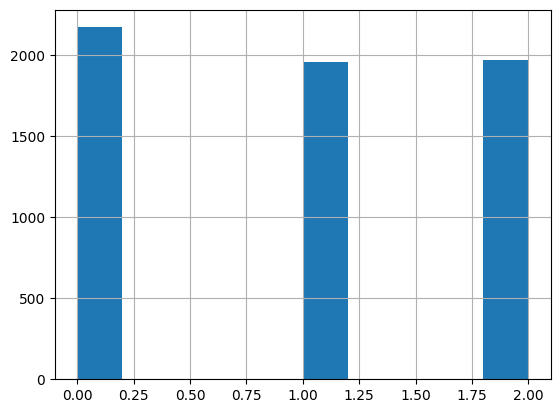

In [ ]:
#@title Look at class balance
train_input['target'].hist()

#Train

In [ ]:
#@title StandardScaler + Final split
scaler = StandardScaler()

train_target=train_input.iloc[:, -1].copy()
train_input=train_input.iloc[:,1 : -3].copy() # -3 to exclude coef and mean_forward

train_input=scaler.fit_transform(train_input)

val_target=val_input.iloc[:, -1].copy()
val_input=val_input.iloc[:,1 : -3].copy()
val_input=scaler.transform(val_input)
val_target=val_target.iloc[train_splitter:]
val_input=val_input[train_splitter:]

test_target=test_input.iloc[:, -1].copy()
test_input=test_input.iloc[:,1 : -3].copy()
test_input=scaler.transform(test_input)
test_target=test_target.iloc[val_splitter:]
test_input=test_input[val_splitter:]

In [ ]:
#@title Set models an Run train
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
catboost_classifier = CatBoostClassifier(iterations=800,
                                         learning_rate=0.2,
                                         depth=6,
                                         l2_leaf_reg=3,
                                         border_count=64,
                                         bagging_temperature=0.5,
                                         random_strength=0.5,
                                         leaf_estimation_iterations=5,
                                         leaf_estimation_method='Newton',
                                         class_weights=[1, 8, 10],
                                         verbose=0)

# Create a list of tuples containing the classifier name and the classifier object
classifiers = [('Random Forest', rf_classifier),
               ('Gradient Boosting', gb_classifier),
               ('CatBoost', catboost_classifier)]

# Initialize the VotingClassifier with the list of classifiers
voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')  # 'soft' voting for probability-based ensemble

# Train the VotingClassifier on the training data
voting_classifier.fit(train_input, train_target)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7b6b936d2050>)],
                 voting='soft')

Ensemble Accuracy: 0.622847543049139
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.52      0.27      0.35       601
           1       0.62      0.80      0.70       886
           2       0.66      0.68      0.67       894

    accuracy                           0.62      2381
   macro avg       0.60      0.58      0.58      2381
weighted avg       0.61      0.62      0.60      2381

Confusion Matrix (Entire Dataset):
[[161 231 209]
 [ 71 712 103]
 [ 78 206 610]]
Confusion Matrix - Entire Dataset:


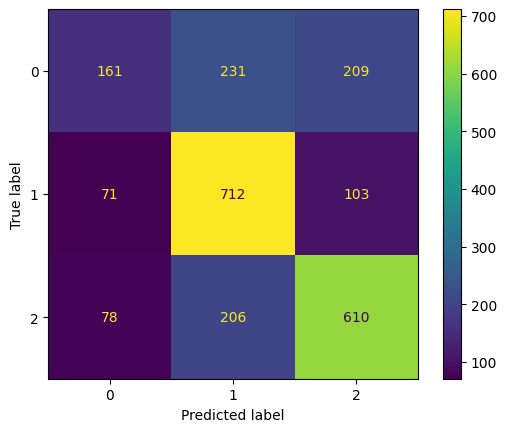

In [ ]:
#@title Test (new) (StandartSclaer)
pred_target = voting_classifier.predict(np.vstack((val_input,test_input)))
accuracy = accuracy_score(np.hstack((val_target.values, test_target.values)), pred_target)
print("Ensemble Accuracy:", accuracy)


print("Classification Report (Entire Dataset):")
print(classification_report(np.hstack((val_target.values, test_target.values)), pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target))
cm_target = confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

In [ ]:
#@title Save VC
joblib.dump(voting_classifier, 'voting_classifier_11042025.pkl')

['voting_classifier_11042025.pkl']

#Spliting test array to test1 as val and test2 as main test. Using val to search right confidence

In [ ]:
predicted_classes = voting_classifier.predict(val_input)
predicted_probs = voting_classifier.predict_proba(val_input)

n_classes = predicted_probs.shape[1]
results_df = pd.DataFrame(predicted_probs, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df['true_target'] = val_target.values
results_df['predicted_target'] = predicted_classes

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df['confidence'] = predicted_probs.max(axis=1)

# Флаг: предсказание правильное или нет
results_df['correct'] = results_df['true_target'] == results_df['predicted_target']

# Вычисляем соотношение между максимальной и второй по величине вероятностью
# Сначала сортируем вероятности по каждой строке
sorted_probs = np.sort(predicted_probs, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.474664      0.363374      0.161962            2                 0   
1      0.204653      0.053943      0.741404            2                 2   
2      0.317051      0.155050      0.527899            2                 2   
3      0.361527      0.189034      0.449438            2                 2   
4      0.275420      0.116891      0.607689            2                 2   

   confidence  correct  ratio_max_second  
0    0.474664    False          1.306268  
1    0.741404     True          3.622739  
2    0.527899     True          1.665028  
3    0.449438     True          1.243165  
4    0.607689     True          2.206413  


In [ ]:
# Средняя уверенность
mean_confidence_correct = results_df[results_df['correct']]['confidence'].mean()
mean_confidence_wrong = results_df[~results_df['correct']]['confidence'].mean()

print("Средняя уверенность на верных предсказаниях:", mean_confidence_correct)
print("Средняя уверенность на ошибочных предсказаниях:", mean_confidence_wrong)

# Среднее соотношение вероятностей (макс/второй максимум)
mean_ratio_correct = results_df[results_df['correct']]['ratio_max_second'].mean()
mean_ratio_wrong = results_df[~results_df['correct']]['ratio_max_second'].mean()

print("Среднее соотношение (макс/второй максимум) на верных предсказаниях:", mean_ratio_correct)
print("Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях:", mean_ratio_wrong)


Средняя уверенность на верных предсказаниях: 0.6468900552870848
Средняя уверенность на ошибочных предсказаниях: 0.559747540525589
Среднее соотношение (макс/второй максимум) на верных предсказаниях: 4.352368608878391
Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях: 2.4794312677545367


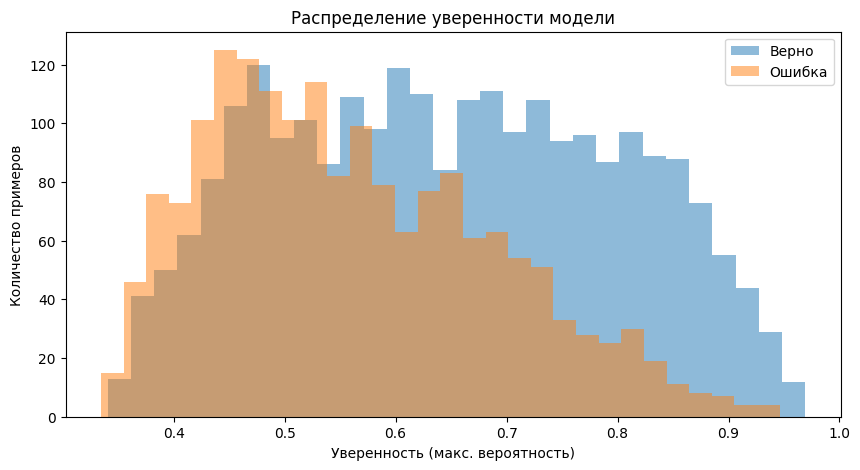

In [ ]:
plt.figure(figsize=(10, 5))

# Гистограмма для верных предсказаний
plt.hist(results_df[results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Верно')

# Гистограмма для ошибочных предсказаний
plt.hist(results_df[~results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Уверенность (макс. вероятность)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности модели')
plt.legend()
plt.show()

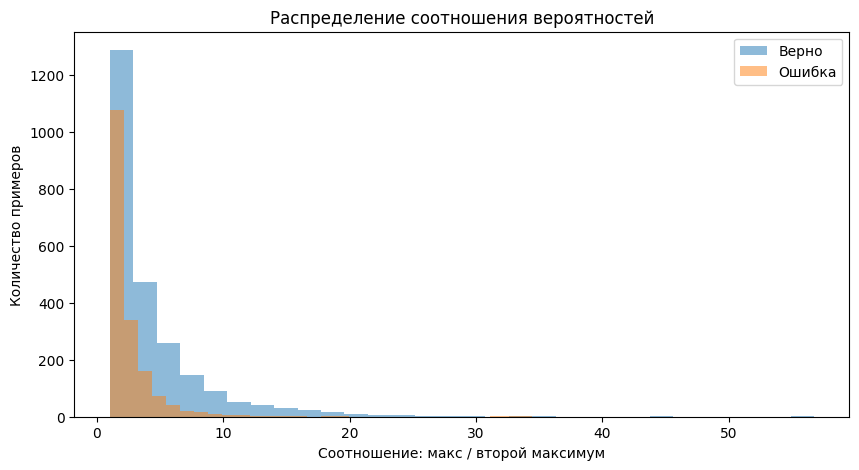

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(results_df[results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Верно')
plt.hist(results_df[~results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Соотношение: макс / второй максимум')
plt.ylabel('Количество примеров')
plt.title('Распределение соотношения вероятностей')
plt.legend()
plt.show()

#Using test with val confidence to predict classes 1 and 2

In [ ]:
predicted_classes2 = voting_classifier.predict(test_input)
predicted_probs2 = voting_classifier.predict_proba(test_input)

n_classes = predicted_probs2.shape[1]
results_df2 = pd.DataFrame(predicted_probs2, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df2['true_target'] = test_target.values
results_df2['predicted_target'] = predicted_classes2

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df2['confidence'] = predicted_probs2.max(axis=1)

# Флаг: предсказание правильное или нет
results_df2['correct'] = results_df2['true_target'] == results_df2['predicted_target']

sorted_probs = np.sort(predicted_probs2, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df2['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df2.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.270380      0.033726      0.695894            2                 2   
1      0.276746      0.010989      0.712266            0                 2   
2      0.546521      0.167592      0.285887            0                 0   
3      0.334944      0.049555      0.615501            0                 2   
4      0.600787      0.161811      0.237402            0                 0   

   confidence  correct  ratio_max_second  
0    0.695894     True          2.573769  
1    0.712266    False          2.573717  
2    0.546521     True          1.911672  
3    0.615501    False          1.837623  
4    0.600787     True          2.530675  


In [ ]:
filtered_df = results_df2[(results_df2['true_target'].isin([1, 2])) & (results_df2['confidence'] > mean_confidence_correct)]
accuracy_filtered = filtered_df['correct'].mean()

print('Всего наблюдений в второй части тестовой выборки: '+str(len(np.vstack((val_input,test_input)))))
print('Всего меток 1 и 2 проставлено моделью: '+str(len(results_df2[(results_df2['true_target'].isin([1, 2]))])))
print('Всего меток, проставленных моделью, осталось после фильтрации: '+str(len(filtered_df)))
print()
print(f"Точность для классов 1 и 2 при уверенности > {mean_confidence_correct}:", accuracy_filtered)

Всего наблюдений в второй части тестовой выборки: 8457
Всего меток 1 и 2 проставлено моделью: 2865
Всего меток, проставленных моделью, осталось после фильтрации: 1348

Точность для классов 1 и 2 при уверенности > 0.6468900552870848: 0.8887240356083086
